In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm, colors

In [2]:
# make a mock dataset for one site, multiple proteins over morning/noon/evening
# not sure what the data usually look like, so i assumed normalized abundances
num_proteins = 10
np.random.seed(0)
df = pd.DataFrame(np.random.uniform(low=0.0, high=1.0, size=(10,3)), columns=['morning', 'noon', 'evening'])
df['protein_name'] = ['protein_'+str(i) for i in df.index]
df_tidy = df.melt(id_vars='protein_name', var_name='time', value_name='norm_abundance')

In [ ]:
# default category plot using seaborn with blue colors but it just colors based on protein, not by the fold change
sns.catplot(data=df_tidy, x="time", y="norm_abundance", hue="protein_name", kind="point", color='tab:blue')

The default seaborn category plot colors based on the protein, but we want to color based on the change. So we may need to plot it manually.

-3.703760191033959 5.363917390273005
['protein_8', 'protein_3'] ['protein_5', 'protein_9'] ['protein_5', 'protein_7'] ['protein_4', 'protein_8']


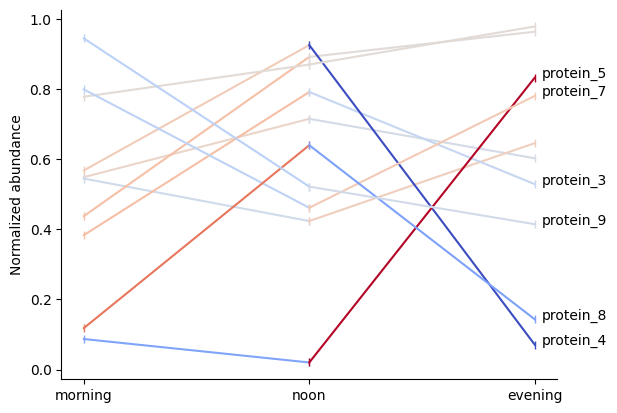

In [20]:
# alternatively, maybe we want for the color to go from gray to red/blue depending on the fold change

# calculate fold changes
df2 = df.copy()
df2['morning_noon_FC'] = df2['noon'] / df2['morning']
df2['noon_evening_FC'] = df2['evening'] / df2['noon']

# log2 fold change
df2['log2_morning_noon_FC'] = np.log2(df2['morning_noon_FC'])
df2['log2_noon_evening_FC'] = np.log2(df2['noon_evening_FC'])

# get the min and max log2 fold change
min_log_FC = np.min(df2.loc[:,['log2_morning_noon_FC','log2_noon_evening_FC']].values)
max_log_FC = np.max(df2.loc[:,['log2_morning_noon_FC','log2_noon_evening_FC']].values)
print(min_log_FC, max_log_FC)

# map the log fold changes to the coolwarm colormap
# may need to change the vmin and vmax depending on the min_log_FC and max_log_FC for your data,
# but make sure it's centered around 0 so that no change is mapped to grey. norm_factor takes care of this for you,
# but you can also assign vmin and vmax manually
norm_factor = min(np.abs(min_log_FC), np.abs(max_log_FC))
norm = colors.Normalize(vmin=-1*norm_factor, vmax=1*norm_factor, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.coolwarm)
df2['morning_noon_mapped_color'] = [mapper.to_rgba(x) for x in df2['log2_morning_noon_FC']]
df2['noon_evening_mapped_color'] = [mapper.to_rgba(x) for x in df2['log2_noon_evening_FC']]

fig, ax = plt.subplots()

top5inc_mornnoon = list(df2.nlargest(2, 'log2_morning_noon_FC').protein_name)
top5dec_mornnoon = list(df2.nsmallest(2, 'log2_morning_noon_FC').protein_name)
top5inc_nooneve = list(df2.nlargest(2, 'log2_noon_evening_FC').protein_name)
top5dec_nooneve = list(df2.nsmallest(2, 'log2_noon_evening_FC').protein_name)

print(top5inc_mornnoon, top5dec_mornnoon, top5inc_nooneve, top5dec_nooneve)

gg = set(top5inc_mornnoon+top5dec_mornnoon+top5inc_nooneve+top5dec_nooneve)

# step through each row and plot it manually
for index,row in df2.iterrows():
    ax.plot([0,1], [row.morning, row.noon], marker='|', color=row.morning_noon_mapped_color)
    ax.plot([1,2], [row.noon, row.evening], marker='|', color=row.noon_evening_mapped_color)
    
    if row.protein_name in gg:
        label = row.protein_name
        ax.annotate(label, (2, row.evening), textcoords = "offset points", xytext = (5,0), ha='left')
    
# manually add labels    
plt.xticks([0,1,2], labels=['morning', 'noon', 'evening'])
plt.ylabel('Normalized abundance')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

In [14]:
'protein_8' in list(df2.nlargest(2, 'log2_morning_noon_FC').protein_name)

True

In [ ]:
# which proteins have the most extreme fold changes?
# sort by log 2 morning_noon_FC so most extreme is at the top and bottom, then get the top and bottom N
N = 3
df2.sort_values(by='log2_morning_noon_FC').iloc[np.r_[0:N, -1*N:0]]


In [ ]:
# sort by log 2 noon_evening_FC so most extreme is at the top and bottom, then get the top and bottom 2
N = 3
df2.sort_values(by='log2_noon_evening_FC').iloc[np.r_[0:N, -1*N:0]]